# Predicting Movie Success/Flop using Movie Attributes and Social Media Data

### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from easymoney.money import EasyPeasy
import warnings
warnings.filterwarnings('ignore')

### Import Data

In [2]:
movies_org = pd.read_csv('data_concat/brands_with_extras_kmodes.csv')
movies_bo = pd.read_csv('data/movie_data_w_bo_fixed.csv')
fb_rollup1 = pd.read_csv('/home/jovyan/capstone_data/listenfirst/data/view_brand_rollup_facebook_1k-10k.tsv', delimiter='\t')
fb_rollup2 = pd.read_csv('/home/jovyan/capstone_data/listenfirst/data/view_brand_rollup_facebook_10kplus.tsv', delimiter='\t')

fb = pd.concat([fb_rollup1, fb_rollup2])

twitter_rollup1 = pd.read_csv('/home/jovyan/capstone_data/listenfirst/data/view_brand_rollup_twitter_1k-10k.tsv', delimiter='\t')
twitter_rollup2 = pd.read_csv('/home/jovyan/capstone_data/listenfirst/data/view_brand_rollup_twitter_10kplus.tsv', delimiter='\t')

twitter = pd.concat([twitter_rollup1, twitter_rollup2])

insta_rollup1 = pd.read_csv('/home/jovyan/capstone_data/listenfirst/data/view_brand_rollup_instagram_1k-10k.tsv', delimiter='\t')
insta_rollup2 = pd.read_csv('/home/jovyan/capstone_data/listenfirst/data/view_brand_rollup_instagram_10kplus.tsv', delimiter='\t')

instagram = pd.concat([insta_rollup1, insta_rollup2])

### Merge Movie attribute data, clean and bin

In [3]:
movies = pd.merge(movies_org, movies_bo, left_on='replace', right_on='Movie')
ep = EasyPeasy()

movies['inflated_boxoffice'] = [ep.normalize(amount=x[1]['DomesticGross_y'], region="US", base_currency="USD", from_year=x[1]['released_year'], to_year="latest") for x in movies.iterrows()]
movies['inflated_boxoffice'] = movies['inflated_boxoffice'].astype(int)
movies_fil = movies[['brand_ods_id', 'replace', 'released_on', 'released_year', 'year_bin',
       'production_company', 'rating', 'source', 'franchise',
       'genre_grouped', 'inflated_budget', 'inflated_boxoffice', 'production_company_bin']]
movies_fil['released_on'] = pd.to_datetime(movies_fil['released_on'])
movies_fil['released_month'] = movies_fil['released_on'].map(lambda x: x.month)
movies_fil['inflated_profit'] = movies_fil['inflated_boxoffice'] - movies_fil['inflated_budget']
movies_fil['profit_bins'] = pd.qcut(movies_fil['inflated_profit'],  q= 3,
                             labels=['Flop', 'Medium Profit', 'Insane Profit'])
movies_fil['successflop'] = pd.qcut(movies_fil['inflated_profit'],  q=[0, .3, 1],
                              labels=['Flop', 'Success'])

### Aggregating Social Media Data from 1 year to 3 months before release

In [4]:
fb.columns = ['movie_id', 'data_for'] + [str(col) + '_facebook' for col in fb.columns[2:]]
fb_merged = pd.merge(fb, movies_fil, left_on = 'movie_id', right_on = 'brand_ods_id', how = 'left')
fb_dropped = fb_merged.dropna(subset=['replace'])
fb_dropped['data_for']= pd.to_datetime(fb_dropped['data_for']) 
fb_dropped['released_on'] = pd.to_datetime(fb_dropped['released_on'])
fb_dropped['days_after_release'] = fb_dropped['data_for'] - fb_dropped['released_on'] 
fb_fil = fb_dropped[(fb_dropped['days_after_release'] <= '-90 days') & (fb_dropped['days_after_release'] >= '-365 days')]
fb_grouped = fb_fil.groupby('movie_id', as_index = False).agg('mean')

fb_grouped = fb_grouped.drop(['brand_ods_id',
       'released_year', 'year_bin', 'inflated_budget', 'inflated_boxoffice',
       'released_month', 'inflated_profit'], axis = 1)

In [5]:
twitter.columns = ['movie_id', 'data_for'] + [str(col) + '_twitter' for col in twitter.columns[2:]]
twitter_merged = pd.merge(twitter, movies_fil, left_on = 'movie_id', right_on = 'brand_ods_id', how = 'left')
twitter_dropped = twitter_merged.dropna(subset=['replace'])
twitter_dropped['data_for']= pd.to_datetime(twitter_dropped['data_for']) 
twitter_dropped['released_on'] = pd.to_datetime(twitter_dropped['released_on'])
twitter_dropped['days_after_release'] = twitter_dropped['data_for'] - twitter_dropped['released_on'] 
twitter_fil = twitter_dropped[(twitter_dropped['days_after_release'] <= '-90 days') & (twitter_dropped['days_after_release'] >= '-365 days')]

twitter_grouped = twitter_fil.groupby('movie_id', as_index = False).agg('mean')
twitter_grouped = twitter_grouped.drop(['brand_ods_id',
       'released_year', 'year_bin', 'inflated_budget', 'inflated_boxoffice',
       'released_month', 'inflated_profit'], axis = 1 )

In [6]:
instagram.columns = ['movie_id', 'data_for'] + [str(col) + '_instagram' for col in instagram.columns[2:]]
instagram_merged = pd.merge(instagram, movies_fil, left_on = 'movie_id', right_on = 'brand_ods_id', how = 'left')
instagram_dropped = instagram_merged.dropna(subset=['replace'])
instagram_dropped['data_for']= pd.to_datetime(instagram_dropped['data_for']) 
instagram_dropped['released_on'] = pd.to_datetime(instagram_dropped['released_on'])
instagram_dropped['days_after_release'] = instagram_dropped['data_for'] - instagram_dropped['released_on'] 
instagram_fil = instagram_dropped[(instagram_dropped['days_after_release'] <= '-90 days') & (instagram_dropped['days_after_release'] >= '-365 days')]
instagram_grouped = instagram_fil.groupby('movie_id', as_index = False).agg('mean')

instagram_grouped = instagram_grouped.drop(['brand_ods_id',
       'released_year', 'year_bin', 'inflated_budget', 'inflated_boxoffice',
       'released_month', 'inflated_profit'], axis = 1)

### Merging Movie attribute data with social media data

In [7]:
movies_fil = pd.merge(movies_fil, fb_grouped, left_on = 'brand_ods_id', right_on = 'movie_id', how = 'left')
movies_fil = pd.merge(movies_fil, twitter_grouped, left_on = 'movie_id', right_on = 'movie_id', how = 'left')
movies_fil = pd.merge(movies_fil, instagram_grouped, left_on = 'movie_id', right_on = 'movie_id', how = 'left')


In [8]:
# Fill NAN cells with 0
movies_fil.update(movies_fil[['likes_c_facebook', 'likes_facebook',
       'talking_about_c_facebook', 'talking_about_facebook',
       'engagement_rate_c_facebook', 'engagement_rate_facebook',
       'total_post_c_facebook', 'total_post_facebook',
       'total_post_likes_c_facebook', 'total_post_likes_facebook',
       'total_post_shares_c_facebook', 'total_post_shares_facebook',
       'total_post_comments_c_facebook', 'total_post_comments_facebook',
       'total_post_love_count_c_facebook', 'total_post_love_count_facebook',
       'total_post_wow_count_c_facebook', 'total_post_wow_count_facebook',
       'total_post_haha_count_c_facebook', 'total_post_haha_count_facebook',
       'total_post_sad_count_c_facebook', 'total_post_sad_count_facebook',
       'total_post_angry_count_c_facebook', 'total_post_angry_count_facebook',
       'total_post_thankful_count_c_facebook',
       'total_post_thankful_count_facebook',
       'total_post_tracked_reactions_c_facebook',
       'total_post_tracked_reactions_facebook',
       'total_post_reactions_count_c_facebook',
       'total_post_reactions_count_facebook',
       'total_post_interactions_c_facebook',
       'total_post_interactions_facebook', 'total_post_video_c_facebook',
       'total_post_video_facebook', 'total_post_video_interactions_c_facebook',
       'total_post_video_interactions_facebook', 'tweets_c_twitter',
       'tweets_twitter', 'followers_c_twitter', 'followers_twitter',
       'mentions_twitter', 'total_mentions_twitter',
       'total_retweets_c_twitter', 'total_retweets_twitter',
       'total_favorites_c_twitter', 'total_favorites_twitter',
       'total_replies_c_twitter', 'total_replies_twitter',
       'tracked_posts_c_twitter', 'tracked_posts_twitter',
       'video_tracked_posts_c_twitter', 'video_tracked_posts_twitter',
       'video_retweets_c_twitter', 'video_retweets_twitter',
       'video_favorites_c_twitter', 'video_favorites_twitter',
       'video_replies_c_twitter', 'video_replies_twitter',
       'video_views_c_twitter', 'video_views_twitter',
       'total_post_interactions_c_twitter', 'total_post_interactions_twitter',
       'hashtag_volume_twitter', 'keyword_volume_twitter',
       'cashtag_volume_twitter', 'avg_tweet_interaction_twitter',
       'media_count_c_instagram', 'media_count_instagram',
       'tracked_posts_c_instagram', 'tracked_posts_instagram',
       'followed_by_count_c_instagram', 'followed_by_count_instagram',
       'follows_count_c_instagram', 'follows_count_instagram',
       'total_likes_c_instagram', 'total_likes_instagram',
       'total_comments_c_instagram', 'total_comments_instagram',
       'total_post_interactions_c_instagram',
       'total_post_interactions_instagram',
       'avg_interactions_per_post_c_instagram',
       'avg_interactions_per_post_instagram']].fillna(0))

### Preparing DataFrames for Models

In [9]:
#Defining Dataframe with Movie Attributes and Social Media Data (movies_test)
movies_test = movies_fil[['rating', 'source', 'franchise', 'genre_grouped',
       'inflated_budget', 'production_company_bin',
       'released_month', 'likes_c_facebook', 'likes_facebook',
       'talking_about_c_facebook', 'talking_about_facebook',
       'engagement_rate_c_facebook', 'engagement_rate_facebook',
       'total_post_c_facebook', 'total_post_facebook',
       'total_post_likes_c_facebook', 'total_post_likes_facebook',
       'total_post_shares_c_facebook', 'total_post_shares_facebook',
       'total_post_comments_c_facebook', 'total_post_comments_facebook',
       'total_post_love_count_c_facebook', 'total_post_love_count_facebook',
       'total_post_wow_count_c_facebook', 'total_post_wow_count_facebook',
       'total_post_haha_count_c_facebook', 'total_post_haha_count_facebook',
       'total_post_sad_count_c_facebook', 'total_post_sad_count_facebook',
       'total_post_angry_count_c_facebook', 'total_post_angry_count_facebook',
       'total_post_thankful_count_c_facebook',
       'total_post_thankful_count_facebook',
       'total_post_tracked_reactions_c_facebook',
       'total_post_tracked_reactions_facebook',
       'total_post_reactions_count_c_facebook',
       'total_post_reactions_count_facebook',
       'total_post_interactions_c_facebook',
       'total_post_interactions_facebook', 'total_post_video_c_facebook',
       'total_post_video_facebook', 'total_post_video_interactions_c_facebook',
       'total_post_video_interactions_facebook', 'tweets_c_twitter',
       'tweets_twitter', 'followers_c_twitter', 'followers_twitter',
       'mentions_twitter', 'total_mentions_twitter',
       'total_retweets_c_twitter', 'total_retweets_twitter',
       'total_favorites_c_twitter', 'total_favorites_twitter',
       'total_replies_c_twitter', 'total_replies_twitter',
       'tracked_posts_c_twitter', 'tracked_posts_twitter',
       'video_tracked_posts_c_twitter', 'video_tracked_posts_twitter',
       'video_retweets_c_twitter', 'video_retweets_twitter',
       'video_favorites_c_twitter', 'video_favorites_twitter',
       'video_replies_c_twitter', 'video_replies_twitter',
       'video_views_c_twitter', 'video_views_twitter',
       'total_post_interactions_c_twitter', 'total_post_interactions_twitter',
       'hashtag_volume_twitter', 'keyword_volume_twitter',
       'cashtag_volume_twitter', 'avg_tweet_interaction_twitter',
       'media_count_c_instagram', 'media_count_instagram',
       'tracked_posts_c_instagram', 'tracked_posts_instagram',
       'followed_by_count_c_instagram', 'followed_by_count_instagram',
       'follows_count_c_instagram', 'follows_count_instagram',
       'total_likes_c_instagram', 'total_likes_instagram',
       'total_comments_c_instagram', 'total_comments_instagram',
       'total_post_interactions_c_instagram',
       'total_post_interactions_instagram',
       'avg_interactions_per_post_c_instagram',
       'avg_interactions_per_post_instagram',  'successflop']]

#Defining Dataframe with only Budget and Social Media Data (movies_final)
movies_final = movies_fil[['inflated_budget', 'likes_c_facebook', 'likes_facebook',
       'talking_about_c_facebook', 'talking_about_facebook',
       'engagement_rate_c_facebook', 'engagement_rate_facebook',
       'total_post_c_facebook', 'total_post_facebook',
       'total_post_likes_c_facebook', 'total_post_likes_facebook',
       'total_post_shares_c_facebook', 'total_post_shares_facebook',
       'total_post_comments_c_facebook', 'total_post_comments_facebook',
       'total_post_love_count_c_facebook', 'total_post_love_count_facebook',
       'total_post_wow_count_c_facebook', 'total_post_wow_count_facebook',
       'total_post_haha_count_c_facebook', 'total_post_haha_count_facebook',
       'total_post_sad_count_c_facebook', 'total_post_sad_count_facebook',
       'total_post_angry_count_c_facebook', 'total_post_angry_count_facebook',
       'total_post_thankful_count_c_facebook',
       'total_post_thankful_count_facebook',
       'total_post_tracked_reactions_c_facebook',
       'total_post_tracked_reactions_facebook',
       'total_post_reactions_count_c_facebook',
       'total_post_reactions_count_facebook',
       'total_post_interactions_c_facebook',
       'total_post_interactions_facebook', 'total_post_video_c_facebook',
       'total_post_video_facebook', 'total_post_video_interactions_c_facebook',
       'total_post_video_interactions_facebook', 'tweets_c_twitter',
       'tweets_twitter', 'followers_c_twitter', 'followers_twitter',
       'mentions_twitter', 'total_mentions_twitter',
       'total_retweets_c_twitter', 'total_retweets_twitter',
       'total_favorites_c_twitter', 'total_favorites_twitter',
       'total_replies_c_twitter', 'total_replies_twitter',
       'tracked_posts_c_twitter', 'tracked_posts_twitter',
       'video_tracked_posts_c_twitter', 'video_tracked_posts_twitter',
       'video_retweets_c_twitter', 'video_retweets_twitter',
       'video_favorites_c_twitter', 'video_favorites_twitter',
       'video_replies_c_twitter', 'video_replies_twitter',
       'video_views_c_twitter', 'video_views_twitter',
       'total_post_interactions_c_twitter', 'total_post_interactions_twitter',
       'hashtag_volume_twitter', 'keyword_volume_twitter',
       'cashtag_volume_twitter', 'avg_tweet_interaction_twitter',
       'media_count_c_instagram', 'media_count_instagram',
       'tracked_posts_c_instagram', 'tracked_posts_instagram',
       'followed_by_count_c_instagram', 'followed_by_count_instagram',
       'follows_count_c_instagram', 'follows_count_instagram',
       'total_likes_c_instagram', 'total_likes_instagram',
       'total_comments_c_instagram', 'total_comments_instagram',
       'total_post_interactions_c_instagram',
       'total_post_interactions_instagram',
       'avg_interactions_per_post_c_instagram',
       'avg_interactions_per_post_instagram',  'successflop']]

In [10]:
# Encoding Categorical variables
from sklearn.preprocessing import LabelEncoder 
  
le = LabelEncoder() 

movies_test["rating"] = movies_test["rating"].astype('category')
movies_test["source"] = movies_test["source"].astype('category')
movies_test["franchise"] = movies_test["franchise"].astype('category')
movies_test["genre_grouped"] = movies_test["genre_grouped"].astype('category')
movies_test["production_company_bin"] = movies_test["production_company_bin"].astype('category')
movies_test["released_month"] = movies_test["released_month"].astype('category')
movies_test["successflop"] = movies_test["successflop"].astype('category')


movies_test["rating"] = le.fit_transform(movies_test["rating"])
movies_test["source"] = le.fit_transform(movies_test["source"])
movies_test["franchise"] = le.fit_transform(movies_test["franchise"])
movies_test["genre_grouped"] = le.fit_transform(movies_test["genre_grouped"])
movies_test["production_company_bin"] = le.fit_transform(movies_test["production_company_bin"])
movies_test["released_month"] = le.fit_transform(movies_test["released_month"])
movies_test["successflop"] = le.fit_transform(movies_test["successflop"])

movies_final["successflop"] = movies_final["successflop"].astype('category')
movies_final["successflop"] = le.fit_transform(movies_final["successflop"])

In [15]:
movies_test.columns

Index(['rating', 'source', 'franchise', 'genre_grouped', 'inflated_budget',
       'production_company_bin', 'released_month', 'likes_c_facebook',
       'likes_facebook', 'talking_about_c_facebook', 'talking_about_facebook',
       'engagement_rate_c_facebook', 'engagement_rate_facebook',
       'total_post_c_facebook', 'total_post_facebook',
       'total_post_likes_c_facebook', 'total_post_likes_facebook',
       'total_post_shares_c_facebook', 'total_post_shares_facebook',
       'total_post_comments_c_facebook', 'total_post_comments_facebook',
       'total_post_love_count_c_facebook', 'total_post_love_count_facebook',
       'total_post_wow_count_c_facebook', 'total_post_wow_count_facebook',
       'total_post_haha_count_c_facebook', 'total_post_haha_count_facebook',
       'total_post_sad_count_c_facebook', 'total_post_sad_count_facebook',
       'total_post_angry_count_c_facebook', 'total_post_angry_count_facebook',
       'total_post_thankful_count_c_facebook',
       'total_p

## Movies with only Numerical Features (movies_final)

### Without Normalizing

#### Extract top 10 most important features

In [114]:
# Extracting using ANOVA F-values
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

X = movies_final.iloc[:,0:83]  #feature columns
y = movies_final.iloc[:,-1]    #label columns

#Use SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                                  Specs      Score
0                       inflated_budget  11.378469
13       total_post_comments_c_facebook   5.246370
19     total_post_haha_count_c_facebook   4.723727
4                talking_about_facebook   4.503240
6              engagement_rate_facebook   4.497621
63               hashtag_volume_twitter   4.480371
82  avg_interactions_per_post_instagram   4.028047
20       total_post_haha_count_facebook   3.939283
42               total_mentions_twitter   3.579434
66        avg_tweet_interaction_twitter   3.398552


[0.06217124 0.01703576 0.01566984 0.01141177 0.01456505 0.01349112
 0.02111437 0.01345874 0.02522057 0.01263315 0.01204776 0.01329992
 0.01152203 0.0142988  0.01038803 0.01010132 0.00981556 0.01255598
 0.0109487  0.01164565 0.00860687 0.01017502 0.00772029 0.00976307
 0.00865971 0.00546885 0.00436079 0.01041834 0.01136505 0.01226136
 0.01228191 0.01292014 0.0102155  0.01487935 0.01179946 0.01266248
 0.01139369 0.01984311 0.01643898 0.01449079 0.01523706 0.01451014
 0.02346602 0.01490179 0.01260353 0.0116754  0.01155328 0.00738704
 0.00755501 0.01421257 0.01210111 0.0130487  0.00995893 0.00929813
 0.01052745 0.00881454 0.01104093 0.00657719 0.00809152 0.0084775
 0.01012956 0.01248945 0.01161935 0.02423672 0.         0.
 0.01319804 0.00993382 0.00997223 0.01035749 0.01056134 0.00997665
 0.00770708 0.01005962 0.0097166  0.00631445 0.00803845 0.00963477
 0.0080014  0.00925742 0.00950195 0.00887752 0.01025816]


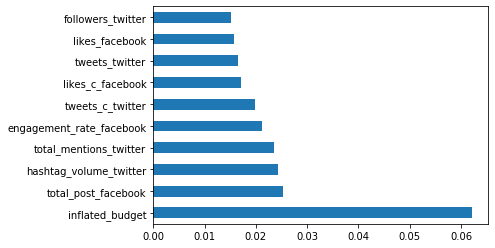

In [115]:
#Comparing ANOVA with using Feature Importance of Extra Trees Classifier

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

#### Choosing features and trying models

In [116]:
movies_final_sel = movies_final[['inflated_budget',
       'total_post_comments_c_facebook',
     'total_post_haha_count_c_facebook',
                'talking_about_facebook',
              'engagement_rate_facebook',
               'hashtag_volume_twitter',
  'avg_interactions_per_post_instagram',
       'total_post_haha_count_facebook',
               'total_mentions_twitter',
        'avg_tweet_interaction_twitter', 'successflop']]


In [117]:
## Importing Models

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz


In [118]:
## Splitting Dataset into train and test
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np

# test_size: what proportion of original data is used for test set
x_train, x_test, y_train, y_test = train_test_split(
   movies_final_sel.loc[:,movies_final_sel.columns != 'successflop'] ,movies_final_sel[['successflop']], random_state=1234, test_size=0.30, shuffle=True)

In [119]:
# Checking Variable importance for Random Forest
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
pd.DataFrame({'features' : x_train.columns.to_numpy(), 'importance':rf.feature_importances_}).sort_values('importance', ascending = False)

,features,importance
0,inflated_budget,0.204857
4,engagement_rate_facebook,0.112875
9,avg_tweet_interaction_twitter,0.106599
3,talking_about_facebook,0.106105
1,total_post_comments_c_facebook,0.100410
5,hashtag_volume_twitter,0.085415
8,total_mentions_twitter,0.083751
7,total_post_haha_count_facebook,0.072553
6,avg_interactions_per_post_instagram,0.069169
2,total_post_haha_count_c_facebook,0.058266


In [120]:
# Initiate Model
logistic_model = LogisticRegression(random_state = 0)
# Model Fitting on Training
logistic_model = logistic_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(logistic_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(logistic_model.predict_proba(x_test))

logistic_acc = metrics.accuracy_score(y_test, predicted)     
logistic_AUC = metrics.roc_auc_score(y_test, probs[1])       
logistic_confusion = metrics.confusion_matrix(y_test, predicted) 
logistic_class_report = metrics.classification_report(y_test, predicted)
logistic_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
logistic_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
logistic_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
logistic_cv_score = cross_val_score(LogisticRegression(), x_test, y_test, scoring='accuracy', cv=10)
logistic_cv_mean = np.mean(logistic_cv_score)


In [23]:
logistic_confusion

array([[24, 26],
       [35, 77]])

In [24]:
# Initiate Model
dtree_model = tree.DecisionTreeClassifier(max_depth=3) 

# Model Fitting on Training
dtree_model = dtree_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(dtree_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(dtree_model.predict_proba(x_test))

dtree_acc = metrics.accuracy_score(y_test, predicted)     
dtree_AUC = metrics.roc_auc_score(y_test, probs[1])       
dtree_confusion = metrics.confusion_matrix(y_test, predicted) 
dtree_class_report = metrics.classification_report(y_test, predicted)
dtree_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
dtree_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
dtree_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
dtree_cv_score = cross_val_score(tree.DecisionTreeClassifier(max_depth=3), x_test, y_test, scoring='accuracy', cv=10)
dtree_cv_mean = np.mean(dtree_cv_score)


In [25]:
# Initiate Model
rf_model = RandomForestClassifier() 

# Model Fitting on Training
rf_model = rf_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(rf_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(rf_model.predict_proba(x_test))

rf_acc = metrics.accuracy_score(y_test, predicted)     
rf_AUC = metrics.roc_auc_score(y_test, probs[1])       
rf_confusion = metrics.confusion_matrix(y_test, predicted) 
rf_class_report = metrics.classification_report(y_test, predicted)
rf_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
rf_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
rf_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
rf_cv_scores = cross_val_score(RandomForestClassifier(), x_test, y_test, scoring='accuracy', cv=10)
rf_cv_mean = np.mean(rf_cv_scores)

In [26]:
# Initiate Model

svm_class_model = SVC(probability=True)

# Model Fitting on Training
svm_class_model = svm_class_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(svm_class_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(svm_class_model.predict_proba(x_test))

svm_class_acc = metrics.accuracy_score(y_test, predicted)     
svm_class_AUC = metrics.roc_auc_score(y_test, probs[1])       
svm_class_confusion = metrics.confusion_matrix(y_test, predicted) 
svm_class_class_report = metrics.classification_report(y_test, predicted)
svm_class_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
svm_class_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
svm_class_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
svm_class_cv_scores = cross_val_score(SVC(probability=True), x_test, y_test, scoring='accuracy', cv=10)
svm_class_cv_mean = np.mean(svm_class_cv_scores)

In [27]:
# Initiate Model
knn_model = KNeighborsClassifier(n_neighbors=3)

# Model Fitting on Training
knn_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(knn_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(knn_model.predict_proba(x_test))

knn_acc = metrics.accuracy_score(y_test, predicted)     
knn_AUC = metrics.roc_auc_score(y_test, probs[1])       
knn_confusion = metrics.confusion_matrix(y_test, predicted) 
knn_class_report = metrics.classification_report(y_test, predicted)
knn_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
knn_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
knn_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
knn_cv_scores = cross_val_score(KNeighborsClassifier(n_neighbors=3), x_test, y_test, scoring='balanced_accuracy', cv=10)
knn_cv_mean = np.mean(knn_cv_scores)
knn_cv_mean

0.5500757575757577

In [28]:
# Instantiate
mlp_model = MLPClassifier(hidden_layer_sizes=(10,10, 1))
# Fit the model
mlp_model.fit(x_train, y_train)
# Accuracy
mlp_model.score(x_train, y_train)


0.32266666666666666

In [29]:
# Predictions/probs on the test dataset
predicted = pd.DataFrame(mlp_model.predict(x_test))
probs = pd.DataFrame(mlp_model.predict_proba(x_test))

mlp_acc = metrics.accuracy_score(y_test, predicted)     
mlp_AUC = metrics.roc_auc_score(y_test, probs[1])       
mlp_confusion = metrics.confusion_matrix(y_test, predicted) 
mlp_class_report = metrics.classification_report(y_test, predicted)
mlp_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
mlp_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
mlp_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
mlp_cv_scores = cross_val_score(mlp_model, x_test, y_test, scoring='accuracy', cv=10)
mlp_cv_mean = np.mean(mlp_cv_scores)
mlp_cv_mean

0.4713235294117647

In [30]:
# Model comparison
models = pd.DataFrame({
  'Model': ['Logistic', 'd.Tree', 'r.f.', 'SVM', 'kNN',  'MLP'],
  'Accuracy' : [logistic_acc, dtree_acc, rf_acc, svm_class_acc, knn_acc, mlp_acc],
  'Precision': [logistic_precision_score, dtree_precision_score, rf_precision_score, svm_class_precision_score, knn_precision_score, mlp_precision_score],
  'recall' : [logistic_recall_score, dtree_recall_score, rf_recall_score, svm_class_recall_score, knn_recall_score, mlp_recall_score],
  'F1' : [logistic_f1_score, dtree_f1_score, rf_f1_score, svm_class_f1_score, knn_f1_score, mlp_f1_score],
  'cv_accuracy' : [logistic_cv_mean, dtree_cv_mean, rf_cv_mean, svm_class_cv_mean, knn_cv_mean, mlp_cv_mean]
})
# Print table and sort by test precision
models.sort_values(by='cv_accuracy', ascending=False)

,Model,Accuracy,Precision,recall,F1,cv_accuracy
3,SVM,0.691358,0.691358,1.000000,0.817518,0.678676
2,r.f.,0.697531,0.726619,0.901786,0.804781,0.665809
1,d.Tree,0.685185,0.694268,0.973214,0.810409,0.659559
0,Logistic,0.623457,0.747573,0.687500,0.716279,0.611397
4,kNN,0.660494,0.720930,0.830357,0.771784,0.550076
5,MLP,0.314815,0.666667,0.017857,0.034783,0.471324


### After Normalizing

In [31]:
movies_final_normalize = movies_final.copy()

In [32]:

num_cols = ['inflated_budget', 'likes_c_facebook', 'likes_facebook',
       'talking_about_c_facebook', 'talking_about_facebook',
       'engagement_rate_c_facebook', 'engagement_rate_facebook',
       'total_post_c_facebook', 'total_post_facebook',
       'total_post_likes_c_facebook', 'total_post_likes_facebook',
       'total_post_shares_c_facebook', 'total_post_shares_facebook',
       'total_post_comments_c_facebook', 'total_post_comments_facebook',
       'total_post_love_count_c_facebook', 'total_post_love_count_facebook',
       'total_post_wow_count_c_facebook', 'total_post_wow_count_facebook',
       'total_post_haha_count_c_facebook', 'total_post_haha_count_facebook',
       'total_post_sad_count_c_facebook', 'total_post_sad_count_facebook',
       'total_post_angry_count_c_facebook', 'total_post_angry_count_facebook',
       'total_post_thankful_count_c_facebook',
       'total_post_thankful_count_facebook',
       'total_post_tracked_reactions_c_facebook',
       'total_post_tracked_reactions_facebook',
       'total_post_reactions_count_c_facebook',
       'total_post_reactions_count_facebook',
       'total_post_interactions_c_facebook',
       'total_post_interactions_facebook', 'total_post_video_c_facebook',
       'total_post_video_facebook', 'total_post_video_interactions_c_facebook',
       'total_post_video_interactions_facebook', 'tweets_c_twitter',
       'tweets_twitter', 'followers_c_twitter', 'followers_twitter',
       'mentions_twitter', 'total_mentions_twitter',
       'total_retweets_c_twitter', 'total_retweets_twitter',
       'total_favorites_c_twitter', 'total_favorites_twitter',
       'total_replies_c_twitter', 'total_replies_twitter',
       'tracked_posts_c_twitter', 'tracked_posts_twitter',
       'video_tracked_posts_c_twitter', 'video_tracked_posts_twitter',
       'video_retweets_c_twitter', 'video_retweets_twitter',
       'video_favorites_c_twitter', 'video_favorites_twitter',
       'video_replies_c_twitter', 'video_replies_twitter',
       'video_views_c_twitter', 'video_views_twitter',
       'total_post_interactions_c_twitter', 'total_post_interactions_twitter',
       'hashtag_volume_twitter', 'keyword_volume_twitter',
       'cashtag_volume_twitter', 'avg_tweet_interaction_twitter',
       'media_count_c_instagram', 'media_count_instagram',
       'tracked_posts_c_instagram', 'tracked_posts_instagram',
       'followed_by_count_c_instagram', 'followed_by_count_instagram',
       'follows_count_c_instagram', 'follows_count_instagram',
       'total_likes_c_instagram', 'total_likes_instagram',
       'total_comments_c_instagram', 'total_comments_instagram',
       'total_post_interactions_c_instagram',
       'total_post_interactions_instagram',
       'avg_interactions_per_post_c_instagram',
       'avg_interactions_per_post_instagram']


# apply standardization on numerical features
    
for i in num_cols:
    
    # fit on training data column
    scale = MinMaxScaler().fit(movies_final_normalize[[i]])
    
    # transform the training data column
    movies_final_normalize[i] = scale.transform(movies_final_normalize[[i]])
    
    # transform the testing data column
    movies_final_normalize[i] = scale.transform(movies_final_normalize[[i]])

In [33]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

X = movies_final_normalize.iloc[:,0:83]  #independent columns
y = movies_final_normalize.iloc[:,-1]    #target column i.e price range
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                                  Specs      Score
0                       inflated_budget  11.378469
13       total_post_comments_c_facebook   5.246370
19     total_post_haha_count_c_facebook   4.723727
4                talking_about_facebook   4.503240
6              engagement_rate_facebook   4.497621
63               hashtag_volume_twitter   4.480371
82  avg_interactions_per_post_instagram   4.028047
20       total_post_haha_count_facebook   3.939283
42               total_mentions_twitter   3.579434
66        avg_tweet_interaction_twitter   3.398552


In [34]:
movies_final_normalized_sel = movies_final_normalize[['inflated_budget',
       'total_post_comments_c_facebook',
     'total_post_haha_count_c_facebook',
                'talking_about_facebook',
              'engagement_rate_facebook',
               'hashtag_volume_twitter',
  'avg_interactions_per_post_instagram',
       'total_post_haha_count_facebook',
               'total_mentions_twitter',
        'avg_tweet_interaction_twitter', 'successflop']]


In [35]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np

# test_size: what proportion of original data is used for test set
x_train, x_test, y_train, y_test = train_test_split(
   movies_final_normalized_sel.loc[:,movies_final_normalized_sel.columns != 'successflop'] ,movies_final_normalized_sel[['successflop']], random_state=1234, test_size=0.30, shuffle=True)

In [36]:
# Variable importance
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
print( "Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), x_train), reverse=True))


Features sorted by their score:
[(0.253, 'total_post_comments_c_facebook'), (0.1961, 'engagement_rate_facebook'), (0.1731, 'total_post_haha_count_c_facebook'), (0.1652, 'hashtag_volume_twitter'), (0.1242, 'total_mentions_twitter'), (0.0529, 'avg_interactions_per_post_instagram'), (0.0172, 'total_post_haha_count_facebook'), (0.0156, 'avg_tweet_interaction_twitter'), (0.0027, 'talking_about_facebook'), (0.0, 'inflated_budget')]


In [37]:
pd.DataFrame({'features' : x_train.columns.to_numpy(), 'importance':rf.feature_importances_}).sort_values('importance', ascending = False)

,features,importance
1,total_post_comments_c_facebook,0.253030
4,engagement_rate_facebook,0.196109
2,total_post_haha_count_c_facebook,0.173101
5,hashtag_volume_twitter,0.165214
8,total_mentions_twitter,0.124228
6,avg_interactions_per_post_instagram,0.052860
7,total_post_haha_count_facebook,0.017215
9,avg_tweet_interaction_twitter,0.015588
3,talking_about_facebook,0.002655
0,inflated_budget,0.000000


In [38]:
# Initiate Model
logistic_model = LogisticRegression(random_state = 0)
# Model Fitting on Training
logistic_model = logistic_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(logistic_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(logistic_model.predict_proba(x_test))

logistic_acc = metrics.accuracy_score(y_test, predicted)     
logistic_AUC = metrics.roc_auc_score(y_test, probs[1])       
logistic_confusion = metrics.confusion_matrix(y_test, predicted) 
logistic_class_report = metrics.classification_report(y_test, predicted)
logistic_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
logistic_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
logistic_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
logistic_cv_score = cross_val_score(LogisticRegression(), x_test, y_test, scoring='accuracy', cv=10)
logistic_cv_mean = np.mean(logistic_cv_score)


In [39]:
# Initiate Model
dtree_model = tree.DecisionTreeClassifier(max_depth=3) 
# Model Fitting on Training
dtree_model = dtree_model.fit(x_train, y_train)
# Test set predictions
predicted = pd.DataFrame(dtree_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(dtree_model.predict_proba(x_test))

dtree_acc = metrics.accuracy_score(y_test, predicted)     
dtree_AUC = metrics.roc_auc_score(y_test, probs[1])       
dtree_confusion = metrics.confusion_matrix(y_test, predicted) 
dtree_class_report = metrics.classification_report(y_test, predicted)
dtree_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
dtree_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
dtree_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
dtree_cv_score = cross_val_score(tree.DecisionTreeClassifier(max_depth=3), x_test, y_test, scoring='accuracy', cv=10)
dtree_cv_mean = np.mean(dtree_cv_score)


In [40]:
# Initiate Model
rf = RandomForestClassifier() 
# Model Fitting on Training
rf_model = rf.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(rf_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(rf_model.predict_proba(x_test))

rf_acc = metrics.accuracy_score(y_test, predicted)     
rf_AUC = metrics.roc_auc_score(y_test, probs[1])       
rf_confusion = metrics.confusion_matrix(y_test, predicted) 
rf_class_report = metrics.classification_report(y_test, predicted)
rf_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
rf_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
rf_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
rf_cv_scores = cross_val_score(RandomForestClassifier(), x_test, y_test, scoring='accuracy', cv=10)
rf_cv_mean = np.mean(rf_cv_scores)
rf_cv_mean

0.6349264705882354

In [41]:
# Initiate Model
svm_class_model = SVC(probability=True)
# Model Fitting on Training
svm_class_model = svm_class_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(svm_class_model.predict(x_test))
probs = pd.DataFrame(svm_class_model.predict_proba(x_test))

# Store metrics
svm_class_acc = metrics.accuracy_score(y_test, predicted)     
svm_class_AUC = metrics.roc_auc_score(y_test, probs[1])       
svm_class_confusion = metrics.confusion_matrix(y_test, predicted) 
svm_class_class_report = metrics.classification_report(y_test, predicted)
svm_class_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
svm_class_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
svm_class_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
svm_class_cv_scores = cross_val_score(SVC(probability=True), x_test, y_test, scoring='accuracy', cv=10)
svm_class_cv_mean = np.mean(svm_class_cv_scores)
svm_class_cv_mean

0.6911764705882353

In [42]:
# Initiate Model
knn_model = KNeighborsClassifier(n_neighbors=3)
# Model Fitting on Training
knn_model.fit(x_train, y_train)
# Test set predictions
predicted = pd.DataFrame(knn_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(knn_model.predict_proba(x_test))

knn_acc = metrics.accuracy_score(y_test, predicted)     
knn_AUC = metrics.roc_auc_score(y_test, probs[1])       
knn_confusion = metrics.confusion_matrix(y_test, predicted) 
knn_class_report = metrics.classification_report(y_test, predicted)
knn_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
knn_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
knn_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
knn_cv_scores = cross_val_score(KNeighborsClassifier(n_neighbors=3), x_test, y_test, scoring='accuracy', cv=10)
knn_cv_mean = np.mean(knn_cv_scores)
knn_cv_mean

0.6430147058823529

In [43]:
# Initiate Model
mlp_model = MLPClassifier(hidden_layer_sizes=(10,10,1))
# Model Fitting on Training
mlp_model.fit(x_train, y_train)


MLPClassifier(hidden_layer_sizes=(10, 10, 1))

# Initiate Model for GridSearchCV
mlp_model = MLPClassifier(max_iter=5000)

parameter_space = {
    'hidden_layer_sizes': [(10,10,50,1), (10,5,1), (10,10,1)],
    'activation': ['logistic', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05,  0.01, 0.001, 0.005, 0.0005],
    'learning_rate': ['constant','adaptive'],
}

from sklearn.model_selection import GridSearchCV

mlp_cv = GridSearchCV(mlp_model, parameter_space, n_jobs=-1, cv=10, scoring = 'accuracy')
mlp_cv.fit(x_train, y_train)


pd.DataFrame(mlp_cv.cv_results_).sort_values('mean_test_score', ascending = False).head(10)


In [45]:
## Using best model parameters to model

# Initiate Model
mlp_model = MLPClassifier(hidden_layer_sizes=(10,10,50, 1), activation = 'logistic', solver = 'sgd', alpha = 0.0001, 
                          learning_rate = 'constant')
# Model Fitting on Training
mlp_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(mlp_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(mlp_model.predict_proba(x_test))

mlp_acc = metrics.accuracy_score(y_test, predicted)     
mlp_AUC = metrics.roc_auc_score(y_test, probs[1])       
mlp_confusion = metrics.confusion_matrix(y_test, predicted) 
mlp_class_report = metrics.classification_report(y_test, predicted)
mlp_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
mlp_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
mlp_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
mlp_cv_scores = cross_val_score(mlp_model, x_test, y_test, scoring='accuracy', cv=10)
mlp_cv_mean = np.mean(mlp_cv_scores)
mlp_cv_mean

0.6536764705882353

In [46]:
# Model comparison
models = pd.DataFrame({
  'Model': ['Logistic', 'd.Tree', 'r.f.', 'SVM', 'kNN',  'MLP'],
  'Accuracy' : [logistic_acc, dtree_acc, rf_acc, svm_class_acc, knn_acc, mlp_acc],
  'Precision': [logistic_precision_score, dtree_precision_score, rf_precision_score, svm_class_precision_score, knn_precision_score, mlp_precision_score],
  'recall' : [logistic_recall_score, dtree_recall_score, rf_recall_score, svm_class_recall_score, knn_recall_score, mlp_recall_score],
  'F1' : [logistic_f1_score, dtree_f1_score, rf_f1_score, svm_class_f1_score, knn_f1_score, mlp_f1_score],
  'cv_accuracy' : [logistic_cv_mean, dtree_cv_mean, rf_cv_mean, svm_class_cv_mean, knn_cv_mean, mlp_cv_mean]
})
# Print table and sort by test precision
models.sort_values(by='cv_accuracy', ascending=False)

,Model,Accuracy,Precision,recall,F1,cv_accuracy
0,Logistic,0.691358,0.691358,1.000000,0.817518,0.691176
3,SVM,0.691358,0.691358,1.000000,0.817518,0.691176
1,d.Tree,0.709877,0.704403,1.000000,0.826568,0.672426
5,MLP,0.691358,0.691358,1.000000,0.817518,0.653676
4,kNN,0.660494,0.724409,0.821429,0.769874,0.643015
2,r.f.,0.679012,0.705479,0.919643,0.798450,0.634926


## Movies with both Numerican and Categorical Features (movies_test)

### Without Normalizing

#### Extract top 10 most important features

In [49]:
# Extracting using ANOVA F-values
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

X = movies_test.iloc[:,0:89]  #feature columns
y = movies_test.iloc[:,-1]    #label columns

#Use SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                                  Specs      Score
4                       inflated_budget  11.378469
1                                source   6.771801
19       total_post_comments_c_facebook   5.246370
25     total_post_haha_count_c_facebook   4.723727
10               talking_about_facebook   4.503240
12             engagement_rate_facebook   4.497621
69               hashtag_volume_twitter   4.480371
88  avg_interactions_per_post_instagram   4.028047
26       total_post_haha_count_facebook   3.939283
2                             franchise   3.861086


[1.57112305e-02 1.81424761e-02 1.08149912e-02 2.23792407e-02
 4.75217338e-02 1.77326844e-02 2.20002628e-02 1.46897185e-02
 1.24854001e-02 9.55014857e-03 1.33231158e-02 1.34275461e-02
 1.83899336e-02 1.43050089e-02 1.84816590e-02 1.30088430e-02
 1.28314409e-02 1.08498146e-02 1.01737259e-02 1.24354454e-02
 1.06222158e-02 8.74134671e-03 7.66636677e-03 1.21653556e-02
 1.02173886e-02 1.07126179e-02 9.17585119e-03 1.04151176e-02
 8.26903525e-03 8.75427110e-03 7.69914966e-03 4.36358276e-03
 3.83136168e-03 1.18823404e-02 1.13446524e-02 1.29997956e-02
 1.17039926e-02 1.17841122e-02 1.04228841e-02 1.31887478e-02
 1.23741550e-02 1.02397975e-02 1.09981144e-02 1.58187440e-02
 1.54508800e-02 1.49477736e-02 1.23182153e-02 1.23698308e-02
 1.92681341e-02 1.10940451e-02 1.13707671e-02 1.01897989e-02
 9.88947048e-03 8.90084531e-03 6.68618393e-03 1.09442611e-02
 1.36490321e-02 1.21052386e-02 9.77289071e-03 8.67539270e-03
 7.86522461e-03 8.50121324e-03 8.34663978e-03 6.10894985e-03
 6.02101037e-03 7.670898

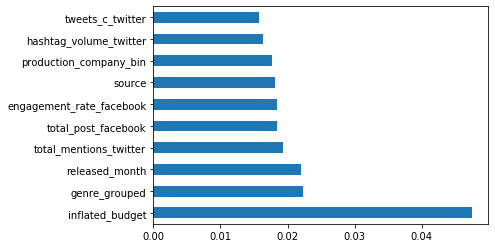

In [50]:
#Comparing ANOVA with using Feature Importance of Extra Trees Classifier

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

#### Choosing features and trying models

In [52]:
movies_test_sel = movies_test[['inflated_budget',
                               'source',
       'total_post_comments_c_facebook',
     'total_post_haha_count_c_facebook',
                'talking_about_facebook',
              'engagement_rate_facebook',
               'hashtag_volume_twitter',
  'avg_interactions_per_post_instagram',
       'total_post_haha_count_facebook',
               'franchise',
                'successflop']]


In [53]:
## Importing Models

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz


In [54]:
## Splitting Dataset into train and test
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np

# test_size: what proportion of original data is used for test set
x_train, x_test, y_train, y_test = train_test_split(
   movies_test_sel.loc[:,movies_test_sel.columns != 'successflop'] ,movies_test_sel[['successflop']], random_state=1234, test_size=0.30, shuffle=True)

In [55]:
# Checking Variable importance for Random Forest
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
pd.DataFrame({'features' : x_train.columns.to_numpy(), 'importance':rf.feature_importances_}).sort_values('importance', ascending = False)

,features,importance
0,inflated_budget,0.200457
9,avg_tweet_interaction_twitter,0.110421
4,engagement_rate_facebook,0.108979
3,talking_about_facebook,0.107144
1,total_post_comments_c_facebook,0.103709
5,hashtag_volume_twitter,0.089170
8,total_mentions_twitter,0.086310
6,avg_interactions_per_post_instagram,0.069425
7,total_post_haha_count_facebook,0.062692
2,total_post_haha_count_c_facebook,0.061693


In [56]:
# Initiate Model
logistic_model = LogisticRegression(random_state = 0)
# Model Fitting on Training
logistic_model = logistic_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(logistic_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(logistic_model.predict_proba(x_test))

logistic_acc = metrics.accuracy_score(y_test, predicted)     
logistic_AUC = metrics.roc_auc_score(y_test, probs[1])       
logistic_confusion = metrics.confusion_matrix(y_test, predicted) 
logistic_class_report = metrics.classification_report(y_test, predicted)
logistic_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
logistic_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
logistic_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
logistic_cv_score = cross_val_score(LogisticRegression(), x_test, y_test, scoring='accuracy', cv=10)
logistic_cv_mean = np.mean(logistic_cv_score)


In [57]:
logistic_confusion

array([[24, 26],
       [35, 77]])

In [58]:
# Initiate Model
dtree_model = tree.DecisionTreeClassifier(max_depth=3) 

# Model Fitting on Training
dtree_model = dtree_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(dtree_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(dtree_model.predict_proba(x_test))

dtree_acc = metrics.accuracy_score(y_test, predicted)     
dtree_AUC = metrics.roc_auc_score(y_test, probs[1])       
dtree_confusion = metrics.confusion_matrix(y_test, predicted) 
dtree_class_report = metrics.classification_report(y_test, predicted)
dtree_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
dtree_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
dtree_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
dtree_cv_score = cross_val_score(tree.DecisionTreeClassifier(max_depth=3), x_test, y_test, scoring='accuracy', cv=10)
dtree_cv_mean = np.mean(dtree_cv_score)


In [59]:
# Initiate Model
rf_model = RandomForestClassifier() 

# Model Fitting on Training
rf_model = rf_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(rf_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(rf_model.predict_proba(x_test))

rf_acc = metrics.accuracy_score(y_test, predicted)     
rf_AUC = metrics.roc_auc_score(y_test, probs[1])       
rf_confusion = metrics.confusion_matrix(y_test, predicted) 
rf_class_report = metrics.classification_report(y_test, predicted)
rf_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
rf_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
rf_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
rf_cv_scores = cross_val_score(RandomForestClassifier(), x_test, y_test, scoring='accuracy', cv=10)
rf_cv_mean = np.mean(rf_cv_scores)

In [60]:
# Initiate Model

svm_class_model = SVC(probability=True)

# Model Fitting on Training
svm_class_model = svm_class_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(svm_class_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(svm_class_model.predict_proba(x_test))

svm_class_acc = metrics.accuracy_score(y_test, predicted)     
svm_class_AUC = metrics.roc_auc_score(y_test, probs[1])       
svm_class_confusion = metrics.confusion_matrix(y_test, predicted) 
svm_class_class_report = metrics.classification_report(y_test, predicted)
svm_class_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
svm_class_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
svm_class_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
svm_class_cv_scores = cross_val_score(SVC(probability=True), x_test, y_test, scoring='accuracy', cv=10)
svm_class_cv_mean = np.mean(svm_class_cv_scores)

In [61]:
# Initiate Model
knn_model = KNeighborsClassifier(n_neighbors=3)

# Model Fitting on Training
knn_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(knn_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(knn_model.predict_proba(x_test))

knn_acc = metrics.accuracy_score(y_test, predicted)     
knn_AUC = metrics.roc_auc_score(y_test, probs[1])       
knn_confusion = metrics.confusion_matrix(y_test, predicted) 
knn_class_report = metrics.classification_report(y_test, predicted)
knn_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
knn_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
knn_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
knn_cv_scores = cross_val_score(KNeighborsClassifier(n_neighbors=3), x_test, y_test, scoring='balanced_accuracy', cv=10)
knn_cv_mean = np.mean(knn_cv_scores)
knn_cv_mean

0.5500757575757577

In [62]:
# Instantiate
mlp_model = MLPClassifier(hidden_layer_sizes=(10,10, 1))
# Fit the model
mlp_model.fit(x_train, y_train)
# Accuracy
mlp_model.score(x_train, y_train)


0.7013333333333334

In [63]:
# Predictions/probs on the test dataset
predicted = pd.DataFrame(mlp_model.predict(x_test))
probs = pd.DataFrame(mlp_model.predict_proba(x_test))

mlp_acc = metrics.accuracy_score(y_test, predicted)     
mlp_AUC = metrics.roc_auc_score(y_test, probs[1])       
mlp_confusion = metrics.confusion_matrix(y_test, predicted) 
mlp_class_report = metrics.classification_report(y_test, predicted)
mlp_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
mlp_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
mlp_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
mlp_cv_scores = cross_val_score(mlp_model, x_test, y_test, scoring='accuracy', cv=10)
mlp_cv_mean = np.mean(mlp_cv_scores)
mlp_cv_mean

0.4588235294117647

In [64]:
# Model comparison
models = pd.DataFrame({
  'Model': ['Logistic', 'd.Tree', 'r.f.', 'SVM', 'kNN',  'MLP'],
  'Accuracy' : [logistic_acc, dtree_acc, rf_acc, svm_class_acc, knn_acc, mlp_acc],
  'Precision': [logistic_precision_score, dtree_precision_score, rf_precision_score, svm_class_precision_score, knn_precision_score, mlp_precision_score],
  'recall' : [logistic_recall_score, dtree_recall_score, rf_recall_score, svm_class_recall_score, knn_recall_score, mlp_recall_score],
  'F1' : [logistic_f1_score, dtree_f1_score, rf_f1_score, svm_class_f1_score, knn_f1_score, mlp_f1_score],
  'cv_accuracy' : [logistic_cv_mean, dtree_cv_mean, rf_cv_mean, svm_class_cv_mean, knn_cv_mean, mlp_cv_mean]
})
# Print table and sort by test precision
models.sort_values(by='cv_accuracy', ascending=False)

,Model,Accuracy,Precision,recall,F1,cv_accuracy
3,SVM,0.691358,0.691358,1.000000,0.817518,0.678676
1,d.Tree,0.685185,0.694268,0.973214,0.810409,0.653309
2,r.f.,0.697531,0.729927,0.892857,0.803213,0.647059
0,Logistic,0.623457,0.747573,0.687500,0.716279,0.611397
4,kNN,0.660494,0.720930,0.830357,0.771784,0.550076
5,MLP,0.685185,0.689441,0.991071,0.813187,0.458824


### After Normalizing

In [65]:
movies_test_normalize = movies_test.copy()

In [66]:

num_cols = ['inflated_budget', 'likes_c_facebook', 'likes_facebook',
       'talking_about_c_facebook', 'talking_about_facebook',
       'engagement_rate_c_facebook', 'engagement_rate_facebook',
       'total_post_c_facebook', 'total_post_facebook',
       'total_post_likes_c_facebook', 'total_post_likes_facebook',
       'total_post_shares_c_facebook', 'total_post_shares_facebook',
       'total_post_comments_c_facebook', 'total_post_comments_facebook',
       'total_post_love_count_c_facebook', 'total_post_love_count_facebook',
       'total_post_wow_count_c_facebook', 'total_post_wow_count_facebook',
       'total_post_haha_count_c_facebook', 'total_post_haha_count_facebook',
       'total_post_sad_count_c_facebook', 'total_post_sad_count_facebook',
       'total_post_angry_count_c_facebook', 'total_post_angry_count_facebook',
       'total_post_thankful_count_c_facebook',
       'total_post_thankful_count_facebook',
       'total_post_tracked_reactions_c_facebook',
       'total_post_tracked_reactions_facebook',
       'total_post_reactions_count_c_facebook',
       'total_post_reactions_count_facebook',
       'total_post_interactions_c_facebook',
       'total_post_interactions_facebook', 'total_post_video_c_facebook',
       'total_post_video_facebook', 'total_post_video_interactions_c_facebook',
       'total_post_video_interactions_facebook', 'tweets_c_twitter',
       'tweets_twitter', 'followers_c_twitter', 'followers_twitter',
       'mentions_twitter', 'total_mentions_twitter',
       'total_retweets_c_twitter', 'total_retweets_twitter',
       'total_favorites_c_twitter', 'total_favorites_twitter',
       'total_replies_c_twitter', 'total_replies_twitter',
       'tracked_posts_c_twitter', 'tracked_posts_twitter',
       'video_tracked_posts_c_twitter', 'video_tracked_posts_twitter',
       'video_retweets_c_twitter', 'video_retweets_twitter',
       'video_favorites_c_twitter', 'video_favorites_twitter',
       'video_replies_c_twitter', 'video_replies_twitter',
       'video_views_c_twitter', 'video_views_twitter',
       'total_post_interactions_c_twitter', 'total_post_interactions_twitter',
       'hashtag_volume_twitter', 'keyword_volume_twitter',
       'cashtag_volume_twitter', 'avg_tweet_interaction_twitter',
       'media_count_c_instagram', 'media_count_instagram',
       'tracked_posts_c_instagram', 'tracked_posts_instagram',
       'followed_by_count_c_instagram', 'followed_by_count_instagram',
       'follows_count_c_instagram', 'follows_count_instagram',
       'total_likes_c_instagram', 'total_likes_instagram',
       'total_comments_c_instagram', 'total_comments_instagram',
       'total_post_interactions_c_instagram',
       'total_post_interactions_instagram',
       'avg_interactions_per_post_c_instagram',
       'avg_interactions_per_post_instagram']


# apply standardization on numerical features
    
for i in num_cols:
    
    # fit on training data column
    scale = MinMaxScaler().fit(movies_test_normalize[[i]])
    
    # transform the training data column
    movies_test_normalize[i] = scale.transform(movies_test_normalize[[i]])
    
    # transform the testing data column
    movies_test_normalize[i] = scale.transform(movies_test_normalize[[i]])

In [67]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

X = movies_test_normalize.iloc[:,0:89]  #independent columns
y = movies_test_normalize.iloc[:,-1]    #target column i.e price range
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                                  Specs      Score
4                       inflated_budget  11.378469
1                                source   6.771801
19       total_post_comments_c_facebook   5.246370
25     total_post_haha_count_c_facebook   4.723727
10               talking_about_facebook   4.503240
12             engagement_rate_facebook   4.497621
69               hashtag_volume_twitter   4.480371
88  avg_interactions_per_post_instagram   4.028047
26       total_post_haha_count_facebook   3.939283
2                             franchise   3.861086


In [68]:
movies_test_normalize_sel = movies_test_normalize[['inflated_budget',
                               'source',
       'total_post_comments_c_facebook',
     'total_post_haha_count_c_facebook',
                'talking_about_facebook',
              'engagement_rate_facebook',
               'hashtag_volume_twitter',
  'avg_interactions_per_post_instagram',
       'total_post_haha_count_facebook',
               'franchise',
                'successflop']]


In [69]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np

# test_size: what proportion of original data is used for test set
x_train, x_test, y_train, y_test = train_test_split(
   movies_test_normalize_sel.loc[:,movies_test_normalize_sel.columns != 'successflop'] ,movies_test_normalize_sel[['successflop']], random_state=1234, test_size=0.30, shuffle=True)

In [70]:
# Variable importance
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
print( "Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), x_train), reverse=True))


Features sorted by their score:
[(0.2654, 'total_post_comments_c_facebook'), (0.2238, 'engagement_rate_facebook'), (0.1787, 'hashtag_volume_twitter'), (0.1749, 'total_post_haha_count_c_facebook'), (0.0585, 'source'), (0.056, 'avg_interactions_per_post_instagram'), (0.0284, 'franchise'), (0.0126, 'total_post_haha_count_facebook'), (0.0018, 'talking_about_facebook'), (0.0, 'inflated_budget')]


In [71]:
pd.DataFrame({'features' : x_train.columns.to_numpy(), 'importance':rf.feature_importances_}).sort_values('importance', ascending = False)

,features,importance
2,total_post_comments_c_facebook,0.265370
5,engagement_rate_facebook,0.223774
6,hashtag_volume_twitter,0.178678
3,total_post_haha_count_c_facebook,0.174901
1,source,0.058473
7,avg_interactions_per_post_instagram,0.055995
9,franchise,0.028389
8,total_post_haha_count_facebook,0.012613
4,talking_about_facebook,0.001807
0,inflated_budget,0.000000


In [72]:
# Initiate Model
logistic_model = LogisticRegression(random_state = 0)
# Model Fitting on Training
logistic_model = logistic_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(logistic_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(logistic_model.predict_proba(x_test))

logistic_acc = metrics.accuracy_score(y_test, predicted)     
logistic_AUC = metrics.roc_auc_score(y_test, probs[1])       
logistic_confusion = metrics.confusion_matrix(y_test, predicted) 
logistic_class_report = metrics.classification_report(y_test, predicted)
logistic_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
logistic_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
logistic_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
logistic_cv_score = cross_val_score(LogisticRegression(), x_test, y_test, scoring='accuracy', cv=10)
logistic_cv_mean = np.mean(logistic_cv_score)


In [73]:
# Initiate Model
dtree_model = tree.DecisionTreeClassifier(max_depth=3) 
# Model Fitting on Training
dtree_model = dtree_model.fit(x_train, y_train)
# Test set predictions
predicted = pd.DataFrame(dtree_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(dtree_model.predict_proba(x_test))

dtree_acc = metrics.accuracy_score(y_test, predicted)     
dtree_AUC = metrics.roc_auc_score(y_test, probs[1])       
dtree_confusion = metrics.confusion_matrix(y_test, predicted) 
dtree_class_report = metrics.classification_report(y_test, predicted)
dtree_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
dtree_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
dtree_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
dtree_cv_score = cross_val_score(tree.DecisionTreeClassifier(max_depth=3), x_test, y_test, scoring='accuracy', cv=10)
dtree_cv_mean = np.mean(dtree_cv_score)


In [74]:
# Initiate Model
rf = RandomForestClassifier() 
# Model Fitting on Training
rf_model = rf.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(rf_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(rf_model.predict_proba(x_test))

rf_acc = metrics.accuracy_score(y_test, predicted)     
rf_AUC = metrics.roc_auc_score(y_test, probs[1])       
rf_confusion = metrics.confusion_matrix(y_test, predicted) 
rf_class_report = metrics.classification_report(y_test, predicted)
rf_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
rf_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
rf_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
rf_cv_scores = cross_val_score(RandomForestClassifier(), x_test, y_test, scoring='accuracy', cv=10)
rf_cv_mean = np.mean(rf_cv_scores)
rf_cv_mean

0.6786764705882353

In [75]:
# Initiate Model
svm_class_model = SVC(probability=True)
# Model Fitting on Training
svm_class_model = svm_class_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(svm_class_model.predict(x_test))
probs = pd.DataFrame(svm_class_model.predict_proba(x_test))

# Store metrics
svm_class_acc = metrics.accuracy_score(y_test, predicted)     
svm_class_AUC = metrics.roc_auc_score(y_test, probs[1])       
svm_class_confusion = metrics.confusion_matrix(y_test, predicted) 
svm_class_class_report = metrics.classification_report(y_test, predicted)
svm_class_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
svm_class_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
svm_class_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
svm_class_cv_scores = cross_val_score(SVC(probability=True), x_test, y_test, scoring='accuracy', cv=10)
svm_class_cv_mean = np.mean(svm_class_cv_scores)
svm_class_cv_mean

0.6911764705882353

In [76]:
# Initiate Model
knn_model = KNeighborsClassifier(n_neighbors=3)
# Model Fitting on Training
knn_model.fit(x_train, y_train)
# Test set predictions
predicted = pd.DataFrame(knn_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(knn_model.predict_proba(x_test))

knn_acc = metrics.accuracy_score(y_test, predicted)     
knn_AUC = metrics.roc_auc_score(y_test, probs[1])       
knn_confusion = metrics.confusion_matrix(y_test, predicted) 
knn_class_report = metrics.classification_report(y_test, predicted)
knn_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
knn_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
knn_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
knn_cv_scores = cross_val_score(KNeighborsClassifier(n_neighbors=3), x_test, y_test, scoring='accuracy', cv=10)
knn_cv_mean = np.mean(knn_cv_scores)
knn_cv_mean

0.6242647058823529

In [77]:
# Initiate Model
mlp_model = MLPClassifier(hidden_layer_sizes=(10,10,1))
# Model Fitting on Training
mlp_model.fit(x_train, y_train)


MLPClassifier(hidden_layer_sizes=(10, 10, 1))

In [78]:
# Initiate Model for GridSearchCV
mlp_model = MLPClassifier(max_iter=5000)

parameter_space = {
    'hidden_layer_sizes': [(10,10,50,1), (10,5,1), (10,10,1)],
    'activation': ['logistic', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05,  0.01, 0.001, 0.005, 0.0005],
    'learning_rate': ['constant','adaptive'],
}

from sklearn.model_selection import GridSearchCV

mlp_cv = GridSearchCV(mlp_model, parameter_space, n_jobs=-1, cv=10, scoring = 'accuracy')
mlp_cv.fit(x_train, y_train)


GridSearchCV(cv=10, estimator=MLPClassifier(max_iter=5000), n_jobs=-1,
             param_grid={'activation': ['logistic', 'relu'],
                         'alpha': [0.0001, 0.05, 0.01, 0.001, 0.005, 0.0005],
                         'hidden_layer_sizes': [(10, 10, 50, 1), (10, 5, 1),
                                                (10, 10, 1)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']},
             scoring='accuracy')

In [79]:
pd.DataFrame(mlp_cv.cv_results_).sort_values('mean_test_score', ascending = False).head(10)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_solver,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,8.365087,6.333686,0.071909,0.041098,logistic,0.0001,"(10, 10, 50, 1)",constant,sgd,"{'activation': 'logistic', 'alpha': 0.0001, 'h...",...,0.710526,0.710526,0.702703,0.702703,0.702703,0.702703,0.702703,0.701351,0.009216,1
1,18.857747,18.826796,0.070974,0.037907,logistic,0.0001,"(10, 10, 50, 1)",constant,adam,"{'activation': 'logistic', 'alpha': 0.0001, 'h...",...,0.710526,0.710526,0.702703,0.702703,0.702703,0.702703,0.702703,0.701351,0.009216,1
92,0.883553,0.333414,0.003223,0.000382,relu,0.05,"(10, 10, 1)",constant,sgd,"{'activation': 'relu', 'alpha': 0.05, 'hidden_...",...,0.710526,0.710526,0.702703,0.702703,0.702703,0.702703,0.702703,0.701351,0.009216,1
93,1.390948,1.697809,0.003753,0.001427,relu,0.05,"(10, 10, 1)",constant,adam,"{'activation': 'relu', 'alpha': 0.05, 'hidden_...",...,0.710526,0.710526,0.702703,0.702703,0.702703,0.702703,0.702703,0.701351,0.009216,1
94,0.449514,0.223427,0.002928,0.000086,relu,0.05,"(10, 10, 1)",adaptive,sgd,"{'activation': 'relu', 'alpha': 0.05, 'hidden_...",...,0.710526,0.710526,0.702703,0.702703,0.702703,0.702703,0.702703,0.701351,0.009216,1
95,3.543766,4.754412,0.011845,0.021952,relu,0.05,"(10, 10, 1)",adaptive,adam,"{'activation': 'relu', 'alpha': 0.05, 'hidden_...",...,0.710526,0.710526,0.702703,0.702703,0.702703,0.702703,0.702703,0.701351,0.009216,1
96,5.726312,4.839846,0.042288,0.043408,relu,0.01,"(10, 10, 50, 1)",constant,sgd,"{'activation': 'relu', 'alpha': 0.01, 'hidden_...",...,0.710526,0.710526,0.702703,0.702703,0.702703,0.702703,0.702703,0.701351,0.009216,1
97,8.357056,7.777122,0.051558,0.041268,relu,0.01,"(10, 10, 50, 1)",constant,adam,"{'activation': 'relu', 'alpha': 0.01, 'hidden_...",...,0.710526,0.710526,0.702703,0.702703,0.702703,0.702703,0.702703,0.701351,0.009216,1
98,11.516268,5.381242,0.043023,0.040588,relu,0.01,"(10, 10, 50, 1)",adaptive,sgd,"{'activation': 'relu', 'alpha': 0.01, 'hidden_...",...,0.710526,0.710526,0.702703,0.702703,0.702703,0.702703,0.702703,0.701351,0.009216,1
99,7.571556,7.123069,0.041085,0.042889,relu,0.01,"(10, 10, 50, 1)",adaptive,adam,"{'activation': 'relu', 'alpha': 0.01, 'hidden_...",...,0.710526,0.710526,0.702703,0.702703,0.702703,0.702703,0.702703,0.701351,0.009216,1


In [80]:
## Using best model parameters to model

# Initiate Model
mlp_model = MLPClassifier(hidden_layer_sizes=(10,10,50, 1), activation = 'logistic', solver = 'sgd', alpha = 0.0001, 
                          learning_rate = 'constant')
# Model Fitting on Training
mlp_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(mlp_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(mlp_model.predict_proba(x_test))

mlp_acc = metrics.accuracy_score(y_test, predicted)     
mlp_AUC = metrics.roc_auc_score(y_test, probs[1])       
mlp_confusion = metrics.confusion_matrix(y_test, predicted) 
mlp_class_report = metrics.classification_report(y_test, predicted)
mlp_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
mlp_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
mlp_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
mlp_cv_scores = cross_val_score(mlp_model, x_test, y_test, scoring='accuracy', cv=10)
mlp_cv_mean = np.mean(mlp_cv_scores)
mlp_cv_mean

0.575

In [81]:
# Model comparison
models = pd.DataFrame({
  'Model': ['Logistic', 'd.Tree', 'r.f.', 'SVM', 'kNN',  'MLP'],
  'Accuracy' : [logistic_acc, dtree_acc, rf_acc, svm_class_acc, knn_acc, mlp_acc],
  'Precision': [logistic_precision_score, dtree_precision_score, rf_precision_score, svm_class_precision_score, knn_precision_score, mlp_precision_score],
  'recall' : [logistic_recall_score, dtree_recall_score, rf_recall_score, svm_class_recall_score, knn_recall_score, mlp_recall_score],
  'F1' : [logistic_f1_score, dtree_f1_score, rf_f1_score, svm_class_f1_score, knn_f1_score, mlp_f1_score],
  'cv_accuracy' : [logistic_cv_mean, dtree_cv_mean, rf_cv_mean, svm_class_cv_mean, knn_cv_mean, mlp_cv_mean]
})
# Print table and sort by test precision
models.sort_values(by='cv_accuracy', ascending=False)

,Model,Accuracy,Precision,recall,F1,cv_accuracy
0,Logistic,0.691358,0.691358,1.000000,0.817518,0.691176
3,SVM,0.691358,0.691358,1.000000,0.817518,0.691176
2,r.f.,0.672840,0.703448,0.910714,0.793774,0.678676
1,d.Tree,0.697531,0.695652,1.000000,0.820513,0.659926
4,kNN,0.586420,0.682927,0.750000,0.714894,0.624265
5,MLP,0.691358,0.691358,1.000000,0.817518,0.575000


## Using KS Score for features

In [98]:
from scipy import stats
def ks_score(df, label_col, pos_lab, neg_lab):
    columns = [x for x in df.columns[2:]]
    stat = [stats.ks_2samp(df[df[label_col] == pos_lab][x], df[df[label_col] == neg_lab][x])[0] for x in df.columns[2:]]
    pvalue = [stats.ks_2samp(df[df[label_col] == pos_lab][x], df[df[label_col] == neg_lab][x])[1] for x in df.columns[2:]]
    ks_df = pd.DataFrame(list(zip(columns,stat, pvalue)), columns =['variable', 'ks_stat', 'p_value'])
    return(ks_df)

In [99]:
movies_sel = movies_fil[['brand_ods_id', 'rating', 'source', 'franchise', 'genre_grouped',
       'inflated_budget', 'production_company_bin',
       'released_month', 'released_on', 'successflop']]


In [100]:
fb_filled = fb.fillna(0)

fb_output = pd.merge(fb_filled, movies_sel, left_on = 'movie_id', right_on = 'brand_ods_id', how = 'left')
fb_output = fb_output.dropna(subset=['brand_ods_id'])
fb_output['data_for']= pd.to_datetime(fb_output['data_for']) 
fb_output['released_on'] = pd.to_datetime(fb_output['released_on'])
fb_output['days_after_release'] = fb_output['data_for'] - fb_output['released_on']
fb_output = fb_output[(fb_output['days_after_release'] <= '0 days') & (fb_output['days_after_release'] >= '-365 days')]
fb_output['days_after_release'] = fb_output['days_after_release'].dt.days

In [44]:
fb_output.to_csv('toby_test.csv')

In [101]:
fb_mean = fb_output.groupby(['successflop','days_after_release'], as_index = False).agg('mean').drop(
    ['movie_id', 'brand_ods_id',
       'inflated_budget', 'released_month'], axis=1)

In [104]:
fb_var_score = ks_score(fb_mean, 'successflop', 'Success', 'Flop')
fb_var_score.sort_values('ks_stat', ascending = False).head(5)

,variable,ks_stat,p_value
19,total_post_haha_count_facebook,0.975410,4.752606e-199
25,total_post_thankful_count_facebook,0.931694,5.243957e-173
21,total_post_sad_count_facebook,0.691257,7.173386e-84
33,total_post_video_facebook,0.685792,2.093151e-82
23,total_post_angry_count_facebook,0.666667,2.039688e-77


In [105]:
insta_filled = instagram.fillna(0)

insta_output = pd.merge(insta_filled, movies_sel, left_on = 'movie_id', right_on = 'brand_ods_id', how = 'left')
insta_output = insta_output.dropna(subset=['brand_ods_id'])
insta_output['data_for']= pd.to_datetime(insta_output['data_for']) 
insta_output['released_on'] = pd.to_datetime(insta_output['released_on'])
insta_output['days_after_release'] = insta_output['data_for'] - insta_output['released_on']
insta_output = insta_output[(insta_output['days_after_release'] <= '0 days') & (insta_output['days_after_release'] >= '-365 days')]
insta_output['days_after_release'] = insta_output['days_after_release'].dt.days

In [106]:
insta_mean = insta_output.groupby(['successflop','days_after_release'], as_index = False).agg('mean').drop(
    ['movie_id', 'brand_ods_id',
       'inflated_budget', 'released_month'], axis=1)


In [109]:
insta_var_score = ks_score(insta_mean, 'successflop', 'Success', 'Flop')
insta_var_score.sort_values('ks_stat', ascending = False).head(5)

,variable,ks_stat,p_value
3,tracked_posts_instagram,0.614754,6.668775e-65
15,avg_interactions_per_post_instagram,0.614754,6.668775e-65
7,follows_count_instagram,0.554645,4.012996e-52
5,followed_by_count_instagram,0.426230,3.331366e-30
4,followed_by_count_c_instagram,0.409836,6.915406e-28


In [110]:
twitter_filled = twitter.fillna(0)

twitter_output = pd.merge(twitter_filled, movies_sel, left_on = 'movie_id', right_on = 'brand_ods_id', how = 'left')
twitter_output = twitter_output.dropna(subset=['brand_ods_id'])
twitter_output['data_for']= pd.to_datetime(insta_output['data_for']) 
twitter_output['released_on'] = pd.to_datetime(insta_output['released_on'])
twitter_output['days_after_release'] = twitter_output['data_for'] - twitter_output['released_on']
twitter_output = twitter_output[(twitter_output['days_after_release'] <= '0 days') & (twitter_output['days_after_release'] >= '-365 days')]
twitter_output['days_after_release'] = twitter_output['days_after_release'].dt.days

In [111]:
twitter_mean = twitter_output.groupby(['successflop','days_after_release'], as_index = False).agg('mean').drop(
    ['movie_id', 'brand_ods_id',
       'inflated_budget', 'released_month'], axis=1)

In [113]:
twitter_var_score = ks_score(twitter_mean, 'successflop', 'Success', 'Flop')
twitter_var_score.sort_values('ks_stat', ascending = False).head(5)

,variable,ks_stat,p_value
29,avg_tweet_interaction_twitter,1.000000,3.002873e-219
21,video_replies_twitter,0.980874,6.519101e-203
11,total_replies_twitter,0.928962,1.425953e-171
23,video_views_twitter,0.918033,5.340549e-166
7,total_retweets_twitter,0.890710,4.731581e-153


### Without Normalizing

#### Choosing features and trying models

In [145]:
movies_ks_sel = movies_final[['inflated_budget',
                            'total_post_haha_count_facebook',
                              'total_post_thankful_count_facebook',
                              'total_post_sad_count_facebook',
                              'total_post_video_facebook',
                              'total_post_angry_count_facebook',
                              'tracked_posts_instagram',
                              'avg_interactions_per_post_instagram',
                              'follows_count_instagram',
                              'followed_by_count_instagram',
                              'followed_by_count_c_instagram',
                              'avg_tweet_interaction_twitter',
                                'video_replies_twitter',
                                'total_replies_twitter',
                                  'video_views_twitter',
                                'total_retweets_twitter',
                             'successflop']]

In [146]:
## Splitting Dataset into train and test

x_train, x_test, y_train, y_test = train_test_split(
   movies_ks_sel.loc[:,movies_ks_sel.columns != 'successflop'] ,movies_ks_sel[['successflop']], random_state=1234, test_size=0.30, shuffle=True)

In [147]:
# Checking Variable importance for Random Forest
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
pd.DataFrame({'features' : x_train.columns.to_numpy(), 'importance':rf.feature_importances_}).sort_values('importance', ascending = False)

,features,importance
0,inflated_budget,0.193152
15,total_retweets_twitter,0.113615
11,avg_tweet_interaction_twitter,0.107268
4,total_post_video_facebook,0.100288
6,tracked_posts_instagram,0.067022
1,total_post_haha_count_facebook,0.056126
7,avg_interactions_per_post_instagram,0.054853
5,total_post_angry_count_facebook,0.053979
8,follows_count_instagram,0.046308
10,followed_by_count_c_instagram,0.042162


In [148]:
# Initiate Model
logistic_model = LogisticRegression(random_state = 0)
# Model Fitting on Training
logistic_model = logistic_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(logistic_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(logistic_model.predict_proba(x_test))

logistic_acc = metrics.accuracy_score(y_test, predicted)     
logistic_AUC = metrics.roc_auc_score(y_test, probs[1])       
logistic_confusion = metrics.confusion_matrix(y_test, predicted) 
logistic_class_report = metrics.classification_report(y_test, predicted)
logistic_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
logistic_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
logistic_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
logistic_cv_score = cross_val_score(LogisticRegression(), x_test, y_test, scoring='accuracy', cv=10)
logistic_cv_mean = np.mean(logistic_cv_score)


In [149]:
logistic_confusion

array([[  1,  49],
       [  1, 111]])

In [150]:
# Initiate Model
dtree_model = tree.DecisionTreeClassifier(max_depth=3) 

# Model Fitting on Training
dtree_model = dtree_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(dtree_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(dtree_model.predict_proba(x_test))

dtree_acc = metrics.accuracy_score(y_test, predicted)     
dtree_AUC = metrics.roc_auc_score(y_test, probs[1])       
dtree_confusion = metrics.confusion_matrix(y_test, predicted) 
dtree_class_report = metrics.classification_report(y_test, predicted)
dtree_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
dtree_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
dtree_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
dtree_cv_score = cross_val_score(tree.DecisionTreeClassifier(max_depth=3), x_test, y_test, scoring='accuracy', cv=10)
dtree_cv_mean = np.mean(dtree_cv_score)


In [151]:
# Initiate Model
rf_model = RandomForestClassifier() 

# Model Fitting on Training
rf_model = rf_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(rf_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(rf_model.predict_proba(x_test))

rf_acc = metrics.accuracy_score(y_test, predicted)     
rf_AUC = metrics.roc_auc_score(y_test, probs[1])       
rf_confusion = metrics.confusion_matrix(y_test, predicted) 
rf_class_report = metrics.classification_report(y_test, predicted)
rf_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
rf_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
rf_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
rf_cv_scores = cross_val_score(RandomForestClassifier(), x_test, y_test, scoring='accuracy', cv=10)
rf_cv_mean = np.mean(rf_cv_scores)

In [152]:
# Initiate Model

svm_class_model = SVC(probability=True)

# Model Fitting on Training
svm_class_model = svm_class_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(svm_class_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(svm_class_model.predict_proba(x_test))

svm_class_acc = metrics.accuracy_score(y_test, predicted)     
svm_class_AUC = metrics.roc_auc_score(y_test, probs[1])       
svm_class_confusion = metrics.confusion_matrix(y_test, predicted) 
svm_class_class_report = metrics.classification_report(y_test, predicted)
svm_class_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
svm_class_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
svm_class_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
svm_class_cv_scores = cross_val_score(SVC(probability=True), x_test, y_test, scoring='accuracy', cv=10)
svm_class_cv_mean = np.mean(svm_class_cv_scores)

In [153]:
# Initiate Model
knn_model = KNeighborsClassifier(n_neighbors=3)

# Model Fitting on Training
knn_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(knn_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(knn_model.predict_proba(x_test))

knn_acc = metrics.accuracy_score(y_test, predicted)     
knn_AUC = metrics.roc_auc_score(y_test, probs[1])       
knn_confusion = metrics.confusion_matrix(y_test, predicted) 
knn_class_report = metrics.classification_report(y_test, predicted)
knn_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
knn_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
knn_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
knn_cv_scores = cross_val_score(KNeighborsClassifier(n_neighbors=3), x_test, y_test, scoring='balanced_accuracy', cv=10)
knn_cv_mean = np.mean(knn_cv_scores)
knn_cv_mean

0.505909090909091

In [154]:
# Instantiate
mlp_model = MLPClassifier(hidden_layer_sizes=(10,10, 1))
# Fit the model
mlp_model.fit(x_train, y_train)
# Accuracy
mlp_model.score(x_train, y_train)


0.2986666666666667

In [155]:
# Predictions/probs on the test dataset
predicted = pd.DataFrame(mlp_model.predict(x_test))
probs = pd.DataFrame(mlp_model.predict_proba(x_test))

mlp_acc = metrics.accuracy_score(y_test, predicted)     
mlp_AUC = metrics.roc_auc_score(y_test, probs[1])       
mlp_confusion = metrics.confusion_matrix(y_test, predicted) 
mlp_class_report = metrics.classification_report(y_test, predicted)
mlp_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
mlp_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
mlp_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
mlp_cv_scores = cross_val_score(mlp_model, x_test, y_test, scoring='accuracy', cv=10)
mlp_cv_mean = np.mean(mlp_cv_scores)
mlp_cv_mean

0.54375

In [156]:
# Model comparison
models = pd.DataFrame({
  'Model': ['Logistic', 'd.Tree', 'r.f.', 'SVM', 'kNN',  'MLP'],
  'Accuracy' : [logistic_acc, dtree_acc, rf_acc, svm_class_acc, knn_acc, mlp_acc],
  'Precision': [logistic_precision_score, dtree_precision_score, rf_precision_score, svm_class_precision_score, knn_precision_score, mlp_precision_score],
  'recall' : [logistic_recall_score, dtree_recall_score, rf_recall_score, svm_class_recall_score, knn_recall_score, mlp_recall_score],
  'F1' : [logistic_f1_score, dtree_f1_score, rf_f1_score, svm_class_f1_score, knn_f1_score, mlp_f1_score],
  'cv_accuracy' : [logistic_cv_mean, dtree_cv_mean, rf_cv_mean, svm_class_cv_mean, knn_cv_mean, mlp_cv_mean]
})
# Print table and sort by test precision
models.sort_values(by='cv_accuracy', ascending=False)

,Model,Accuracy,Precision,recall,F1,cv_accuracy
3,SVM,0.691358,0.691358,1.000000,0.817518,0.678676
2,r.f.,0.697531,0.717241,0.928571,0.809339,0.616544
1,d.Tree,0.691358,0.696203,0.982143,0.814815,0.585294
0,Logistic,0.691358,0.693750,0.991071,0.816176,0.580515
5,MLP,0.308642,0.000000,0.000000,0.000000,0.543750
4,kNN,0.685185,0.729323,0.866071,0.791837,0.505909


### After Normalizing

In [159]:
movies_ks_normalize = movies_ks_sel.copy()

In [160]:

num_cols = ['inflated_budget',
                            'total_post_haha_count_facebook',
                              'total_post_thankful_count_facebook',
                              'total_post_sad_count_facebook',
                              'total_post_video_facebook',
                              'total_post_angry_count_facebook',
                              'tracked_posts_instagram',
                              'avg_interactions_per_post_instagram',
                              'follows_count_instagram',
                              'followed_by_count_instagram',
                              'followed_by_count_c_instagram',
                              'avg_tweet_interaction_twitter',
                                'video_replies_twitter',
                                'total_replies_twitter',
                                  'video_views_twitter',
                                'total_retweets_twitter',]


# apply standardization on numerical features
    
for i in num_cols:
    
    # fit on training data column
    scale = MinMaxScaler().fit(movies_ks_normalize[[i]])
    
    # transform the training data column
    movies_ks_normalize[i] = scale.transform(movies_ks_normalize[[i]])
    
    # transform the testing data column
    movies_ks_normalize[i] = scale.transform(movies_ks_normalize[[i]])

In [161]:
# test_size: what proportion of original data is used for test set
x_train, x_test, y_train, y_test = train_test_split(
   movies_ks_normalize.loc[:,movies_ks_normalize.columns != 'successflop'] ,movies_ks_normalize[['successflop']], random_state=1234, test_size=0.30, shuffle=True)

In [162]:
# Variable importance
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
print( "Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), x_train), reverse=True))


Features sorted by their score:
[(0.2106, 'total_post_video_facebook'), (0.1776, 'tracked_posts_instagram'), (0.1686, 'followed_by_count_c_instagram'), (0.1137, 'total_post_thankful_count_facebook'), (0.091, 'video_replies_twitter'), (0.0665, 'avg_interactions_per_post_instagram'), (0.0487, 'follows_count_instagram'), (0.0352, 'total_replies_twitter'), (0.0317, 'avg_tweet_interaction_twitter'), (0.0274, 'total_post_angry_count_facebook'), (0.0232, 'total_post_haha_count_facebook'), (0.0056, 'total_post_sad_count_facebook'), (0.0, 'video_views_twitter'), (0.0, 'total_retweets_twitter'), (0.0, 'inflated_budget'), (0.0, 'followed_by_count_instagram')]


In [163]:
pd.DataFrame({'features' : x_train.columns.to_numpy(), 'importance':rf.feature_importances_}).sort_values('importance', ascending = False)

,features,importance
4,total_post_video_facebook,0.210583
6,tracked_posts_instagram,0.177626
10,followed_by_count_c_instagram,0.168621
2,total_post_thankful_count_facebook,0.113736
12,video_replies_twitter,0.090960
7,avg_interactions_per_post_instagram,0.066537
8,follows_count_instagram,0.048738
13,total_replies_twitter,0.035213
11,avg_tweet_interaction_twitter,0.031749
5,total_post_angry_count_facebook,0.027438


In [164]:
# Initiate Model
logistic_model = LogisticRegression(random_state = 0)
# Model Fitting on Training
logistic_model = logistic_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(logistic_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(logistic_model.predict_proba(x_test))

logistic_acc = metrics.accuracy_score(y_test, predicted)     
logistic_AUC = metrics.roc_auc_score(y_test, probs[1])       
logistic_confusion = metrics.confusion_matrix(y_test, predicted) 
logistic_class_report = metrics.classification_report(y_test, predicted)
logistic_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
logistic_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
logistic_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
logistic_cv_score = cross_val_score(LogisticRegression(), x_test, y_test, scoring='accuracy', cv=10)
logistic_cv_mean = np.mean(logistic_cv_score)


In [165]:
# Initiate Model
dtree_model = tree.DecisionTreeClassifier(max_depth=3) 
# Model Fitting on Training
dtree_model = dtree_model.fit(x_train, y_train)
# Test set predictions
predicted = pd.DataFrame(dtree_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(dtree_model.predict_proba(x_test))

dtree_acc = metrics.accuracy_score(y_test, predicted)     
dtree_AUC = metrics.roc_auc_score(y_test, probs[1])       
dtree_confusion = metrics.confusion_matrix(y_test, predicted) 
dtree_class_report = metrics.classification_report(y_test, predicted)
dtree_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
dtree_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
dtree_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
dtree_cv_score = cross_val_score(tree.DecisionTreeClassifier(max_depth=3), x_test, y_test, scoring='accuracy', cv=10)
dtree_cv_mean = np.mean(dtree_cv_score)


In [166]:
# Initiate Model
rf = RandomForestClassifier() 
# Model Fitting on Training
rf_model = rf.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(rf_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(rf_model.predict_proba(x_test))

rf_acc = metrics.accuracy_score(y_test, predicted)     
rf_AUC = metrics.roc_auc_score(y_test, probs[1])       
rf_confusion = metrics.confusion_matrix(y_test, predicted) 
rf_class_report = metrics.classification_report(y_test, predicted)
rf_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
rf_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
rf_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
rf_cv_scores = cross_val_score(RandomForestClassifier(), x_test, y_test, scoring='accuracy', cv=10)
rf_cv_mean = np.mean(rf_cv_scores)
rf_cv_mean

0.6599264705882353

In [167]:
# Initiate Model
svm_class_model = SVC(probability=True)
# Model Fitting on Training
svm_class_model = svm_class_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(svm_class_model.predict(x_test))
probs = pd.DataFrame(svm_class_model.predict_proba(x_test))

# Store metrics
svm_class_acc = metrics.accuracy_score(y_test, predicted)     
svm_class_AUC = metrics.roc_auc_score(y_test, probs[1])       
svm_class_confusion = metrics.confusion_matrix(y_test, predicted) 
svm_class_class_report = metrics.classification_report(y_test, predicted)
svm_class_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
svm_class_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
svm_class_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
svm_class_cv_scores = cross_val_score(SVC(probability=True), x_test, y_test, scoring='accuracy', cv=10)
svm_class_cv_mean = np.mean(svm_class_cv_scores)
svm_class_cv_mean

0.6911764705882353

In [168]:
# Initiate Model
knn_model = KNeighborsClassifier(n_neighbors=3)
# Model Fitting on Training
knn_model.fit(x_train, y_train)
# Test set predictions
predicted = pd.DataFrame(knn_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(knn_model.predict_proba(x_test))

knn_acc = metrics.accuracy_score(y_test, predicted)     
knn_AUC = metrics.roc_auc_score(y_test, probs[1])       
knn_confusion = metrics.confusion_matrix(y_test, predicted) 
knn_class_report = metrics.classification_report(y_test, predicted)
knn_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
knn_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
knn_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
knn_cv_scores = cross_val_score(KNeighborsClassifier(n_neighbors=3), x_test, y_test, scoring='accuracy', cv=10)
knn_cv_mean = np.mean(knn_cv_scores)
knn_cv_mean

0.5860294117647059

In [169]:
# Initiate Model
mlp_model = MLPClassifier(hidden_layer_sizes=(10,10,1))
# Model Fitting on Training
mlp_model.fit(x_train, y_train)


MLPClassifier(hidden_layer_sizes=(10, 10, 1))

# Initiate Model for GridSearchCV
mlp_model = MLPClassifier(max_iter=5000)

parameter_space = {
    'hidden_layer_sizes': [(10,10,50,1), (10,5,1), (10,10,1)],
    'activation': ['logistic', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05,  0.01, 0.001, 0.005, 0.0005],
    'learning_rate': ['constant','adaptive'],
}

from sklearn.model_selection import GridSearchCV

mlp_cv = GridSearchCV(mlp_model, parameter_space, n_jobs=-1, cv=10, scoring = 'accuracy')
mlp_cv.fit(x_train, y_train)


pd.DataFrame(mlp_cv.cv_results_).sort_values('mean_test_score', ascending = False).head(10)


In [171]:
## Using best model parameters to model

# Initiate Model
mlp_model = MLPClassifier(hidden_layer_sizes=(10,10,50, 1), activation = 'logistic', solver = 'sgd', alpha = 0.0001, 
                          learning_rate = 'constant')
# Model Fitting on Training
mlp_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(mlp_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(mlp_model.predict_proba(x_test))

mlp_acc = metrics.accuracy_score(y_test, predicted)     
mlp_AUC = metrics.roc_auc_score(y_test, probs[1])       
mlp_confusion = metrics.confusion_matrix(y_test, predicted) 
mlp_class_report = metrics.classification_report(y_test, predicted)
mlp_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
mlp_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
mlp_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
mlp_cv_scores = cross_val_score(mlp_model, x_test, y_test, scoring='accuracy', cv=10)
mlp_cv_mean = np.mean(mlp_cv_scores)
mlp_cv_mean

0.5411764705882354

In [172]:
# Model comparison
models = pd.DataFrame({
  'Model': ['Logistic', 'd.Tree', 'r.f.', 'SVM', 'kNN',  'MLP'],
  'Accuracy' : [logistic_acc, dtree_acc, rf_acc, svm_class_acc, knn_acc, mlp_acc],
  'Precision': [logistic_precision_score, dtree_precision_score, rf_precision_score, svm_class_precision_score, knn_precision_score, mlp_precision_score],
  'recall' : [logistic_recall_score, dtree_recall_score, rf_recall_score, svm_class_recall_score, knn_recall_score, mlp_recall_score],
  'F1' : [logistic_f1_score, dtree_f1_score, rf_f1_score, svm_class_f1_score, knn_f1_score, mlp_f1_score],
  'cv_accuracy' : [logistic_cv_mean, dtree_cv_mean, rf_cv_mean, svm_class_cv_mean, knn_cv_mean, mlp_cv_mean]
})
# Print table and sort by test precision
models.sort_values(by='cv_accuracy', ascending=False)

,Model,Accuracy,Precision,recall,F1,cv_accuracy
0,Logistic,0.691358,0.691358,1.000000,0.817518,0.691176
3,SVM,0.691358,0.691358,1.000000,0.817518,0.691176
2,r.f.,0.654321,0.679487,0.946429,0.791045,0.659926
1,d.Tree,0.679012,0.687500,0.982143,0.808824,0.654779
4,kNN,0.629630,0.700000,0.812500,0.752066,0.586029
5,MLP,0.691358,0.691358,1.000000,0.817518,0.541176
